# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [22]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [23]:
# YOUR CODE HERE
data.loc[18]["verse"]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [24]:
!pip install Unidecode

You should consider upgrading via the '/Users/catherinechen/.pyenv/versions/3.8.6/envs/data/bin/python3.8 -m pip install --upgrade pip' command.


In [25]:
from unidecode import unidecode

data["verse"] = data["verse"].map(unidecode)


Let's check:

In [26]:
data.loc[18]["verse"]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [27]:
# YOUR CODE HERE

# original shape
print("initial lenght:",data.shape[0])

# Original data lenght minus data length without duplicates
duplicate_count = len(data)-len(data.drop_duplicates()) 

print("there are", duplicate_count,"duplicates")

initial lenght: 3975
there are 944 duplicates


In [28]:
data.drop_duplicates(inplace = True)

In [29]:
#check the shape post drop duplicates
print("post drop duplicates lenght:",data.shape[0])

post drop duplicates lenght: 3031


In [30]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [31]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [32]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [33]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [34]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [35]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [36]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [37]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.text import text_to_word_sequence

data["seq"] = data["verse"].apply(text_to_word_sequence)

In [38]:
data.head()

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

<AxesSubplot:xlabel='seq', ylabel='Density'>

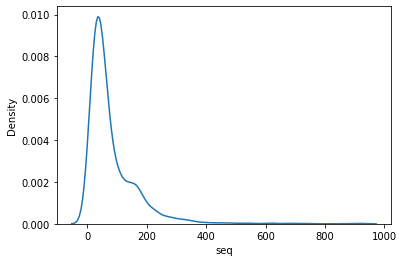

In [39]:
# YOUR CODE HERE
sns.kdeplot(data.seq.apply(len))

=> Yes it seems reasonable to limit ourself to 300 words per verse later on as 90 to 95% of sentences have less than 300 words

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [45]:
# YOUR CODE HERE

def cut_300(word_list):
    if len(word_list) > 300:
        return word_list[:300]
    else:
        return word_list
    
data["seq"] = data["seq"].apply(cut_300)

Check :

<AxesSubplot:xlabel='seq', ylabel='Density'>

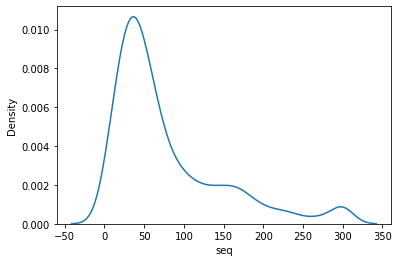

In [46]:
sns.kdeplot(data.seq.apply(len))

In [47]:
data.seq.apply(len).max()

300

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [49]:
# YOUR CODE HERE

from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=data.seq, min_count = 0, iter = 50)
wv = word2vec.wv


In [53]:
wv["pipe"]

array([-0.72932416,  0.923317  ,  0.8763633 , -1.0270467 , -0.6944798 ,
       -0.9725857 ,  0.33618847,  0.9882564 , -0.75080496,  0.36413103,
        1.4186004 ,  0.09223532,  0.56209326,  0.853936  ,  0.14061001,
       -0.48152098, -1.7842509 ,  0.6451913 ,  0.38809073, -0.22356209,
       -1.1531852 , -0.8272319 , -0.10143517,  1.4644291 , -0.01440415,
        1.5677814 , -1.3196149 ,  0.14046243, -0.08391367, -0.31919622,
        0.08969776, -1.5554383 , -0.7010027 ,  0.71172905,  1.2845646 ,
       -0.15737212, -0.5192897 , -2.8738384 , -0.20168175,  0.32181042,
        0.84320366,  0.01199361, -0.2264215 ,  0.16549207,  0.79879147,
       -0.80510294, -0.8115931 , -0.1972196 ,  2.3981364 ,  0.18918161,
       -0.55015737, -1.9305274 ,  1.7500693 , -0.99319696,  0.15229076,
       -0.03893948, -0.97053003,  1.4857424 , -1.1873068 ,  0.24331349,
       -0.9516416 ,  2.161291  , -0.43511444,  0.95694417,  0.36304402,
        0.08454794, -0.9764566 ,  0.613864  , -1.9281529 , -0.82

In [86]:
# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence(word2vec, sentence)
        embed.append(embedded_sentence)
        
    return embed

In [90]:
len(embedding(word2vec, data.seq[0]))

5

In [91]:
data["embed"] = embedding(word2vec, data.seq)

In [92]:
# Check 
assert len(data['embed']) == len(data)

In [94]:
len(data.embed[0])

5

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [95]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.sequence import pad_sequences

#let's pad
X = pad_sequences(data.embed, dtype='float32', padding='post', maxlen=300)

In [96]:
X.shape

(3031, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [98]:
# YOUR CODE HERE
from sklearn.preprocessing import OneHotEncoder

y_ohe = OneHotEncoder(sparse=False) # Instanciate One hot encoder
y_ohe.fit(data[['artist']]) # Fit one hot encoder
y_ohe.categories_

[array(['Drake', 'Ed Sheeran', 'Kanye West'], dtype=object)]

In [102]:
y = pd.DataFrame(y_ohe.transform(data[["artist"]]), columns = list(y_ohe.categories_[0]))

In [103]:
y.shape

(3031, 3)

👉 We train/test split the dataset below for you

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [105]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

In [113]:
!curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle > data_lyrics_solution.pickle

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  693M  100  693M    0     0  1085k      0  0:10:54  0:10:54 --:--:-- 1099k0     0  1051k      0  0:11:15  0:00:11  0:11:04 1073k 0     0  1053k      0  0:11:14  0:00:13  0:11:01 1047k  0     0  1079k      0  0:10:58  0:00:32  0:10:26 1122k9:53 1121k    0     0  1083k      0  0:10:55  0:01:15  0:09:40 1126k     0  1082k      0  0:10:56  0:01:29  0:09:27 1071k21M    0     0  1088k      0  0:10:52  0:01:54  0:08:58 1131k32M    0     0  1089k      0  0:10:51  0:02:04  0:08:47 1115k87M    0     0  1092k      0  0:10:50  0:02:55  0:07:55 1136k0  1091k      0  0:10:51  0:03:24  0:07:27 1077k   0  1093k      0  0:10:49  0:03:38  0:07:11 1142kM    0     0  1092k      0  0:10:50  0:03:57  0:06:53 1074k  0     0  1090k      0  0:10:51  0:04:30  0:06:21 1105k   0  1079k      0  0:10:58  0:05:09  0:05:49 1098k  1076k      0  0:11:00  0:05:

In [115]:
import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)

In [116]:
! rm data_lyrics_solution.pickle

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [114]:
y_train.value_counts()

Drake  Ed Sheeran  Kanye West
1.0    0.0         0.0           1107
0.0    1.0         0.0            701
       0.0         1.0            616
dtype: int64

In [135]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

In [136]:
score_baseline = data['artist'].value_counts()[0]/data['artist'].count()

In [137]:
score_baseline

0.45892444737710325

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [129]:
# YOUR CODE HERE

from tensorflow.keras import Sequential
from tensorflow.keras import layers

def init_model():
    model = Sequential()
    model.add(layers.Masking())
    
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

model = init_model()

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [130]:
# YOUR CODE HERE

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train, 
          batch_size = 32,
          epochs=100,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/100
53/53 [==============================] - 9s 177ms/step - loss: 1.0691 - accuracy: 0.4275 - val_loss: 1.0337 - val_accuracy: 0.4863
Epoch 2/100
53/53 [==============================] - 7s 139ms/step - loss: 0.9735 - accuracy: 0.5542 - val_loss: 0.9830 - val_accuracy: 0.5302
Epoch 3/100
53/53 [==============================] - 7s 140ms/step - loss: 0.8827 - accuracy: 0.6167 - val_loss: 0.9269 - val_accuracy: 0.5687
Epoch 4/100
53/53 [==============================] - 7s 140ms/step - loss: 0.7860 - accuracy: 0.6739 - val_loss: 0.8909 - val_accuracy: 0.5852
Epoch 5/100
53/53 [==============================] - 8s 148ms/step - loss: 0.6958 - accuracy: 0.7099 - val_loss: 0.8698 - val_accuracy: 0.6181
Epoch 6/100
53/53 [==============================] - 9s 174ms/step - loss: 0.6208 - accuracy: 0.7506 - val_loss: 0.8653 - val_accuracy: 0.6181
Epoch 7/100
53/53 [==============================] - 8s 143ms/step - loss: 0.5465 - accuracy: 0.7889 - val_loss: 0.8463 - val_accuracy: 0.6401

❓ **Plot the training and validation losses through training**

In [131]:
history

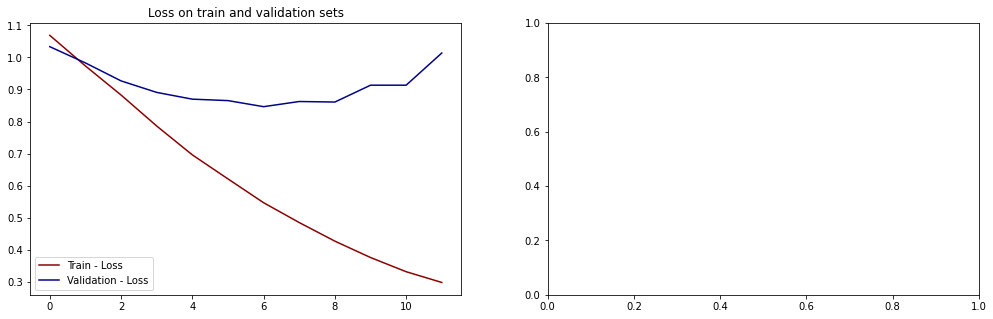

In [132]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE

# This function allows to plot the history of the training of the model
def plot_history(history):
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 5))
    
    axes[0].plot(history.history['loss'], color = 'darkred', label = 'Train - Loss')
    axes[0].plot(history.history['val_loss'], color = 'darkblue', label = 'Validation - Loss')
    axes[0].legend()
    axes[0].set_title('Loss on train and validation sets')    


plot_history(history)


No time to tune the model in order to reduce the overfitting... have to tune the learning rate...

❓ **Save your accuracy on test set as `score_test`**

In [133]:
# YOUR CODE HERE
res = model.evaluate(X_test, y_test, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

The accuracy evaluated on the test set is of 62.109%


In [134]:
score_test = res[1]

🧪 **Send your results below**

In [138]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()